In [1]:
import json
import os
import sys

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from vvc import config

In [2]:
dataset_folder = config.video_folder

experiment_folder = os.path.join(config.base_folder, 'Videos', 'yolov3-transfer')

annotations_file = 'MOV_0861.mp4.json'

test_file = os.path.join(dataset_folder, annotations_file)
experiment_file = os.path.join(experiment_folder, annotations_file)

experiment_file

'/home/juan/workspace/Maestria/Videos/yolov3-transfer/MOV_0861.mp4.json'

In [3]:
def vott_to_dataframe(json_file):
    test_annotations = {}

    df = pd.DataFrame()

    with open(json_file) as json_data:
        data = json.load(json_data)

        for frame_id, boxes in data['frames'].items():
            if not frame_id in test_annotations:
                test_annotations[frame_id] = {}
            for box in boxes:
                for tag in box['tags']:
                    if not tag in test_annotations[frame_id]:
                        test_annotations[frame_id][tag] = 0
                    test_annotations[frame_id][tag] += 1

    df = pd.DataFrame.from_dict(test_annotations, orient='index')
    df = df.fillna(0)
    df = df.drop(columns=['ignore'])
    df = df.set_index(pd.to_numeric(df.index))
    df = df.sort_index(kind='mergesort')
    
    return df
    
test = vott_to_dataframe(test_file)
test.iloc[4:].head()

,car,motorbike
5,3,3.0
6,3,3.0
7,3,3.0
8,3,3.0
9,3,3.0


In [4]:
def vvc_to_df(json_file):
    count_summary = {}
    time_summary = {}

    df = pd.DataFrame()
    
    times = pd.DataFrame()

    with open(json_file) as json_data:
        data = json.load(json_data)
        for frame_id, objects in data['frames'].items():
            
            # Extract counts
            if not frame_id in count_summary:
                count_summary[frame_id] = {}
            
            for obj in objects['objects']:
                tag = obj['tag']
                
                if not tag in count_summary[frame_id]:
                    count_summary[frame_id][tag] = 0
                
                count_summary[frame_id][tag] += 1
                
            # Extract running time
            if not frame_id in time_summary:
                time_summary[frame_id] = {}
                
            for key, value in objects['timestamps'].items():
                time_summary[frame_id][key] = value

    df = pd.DataFrame.from_dict(count_summary, orient='index')
    df = df.fillna(0)
    df = df.set_index(pd.to_numeric(df.index))
    df = df.sort_index(kind='mergesort')
    df = df.reindex(sorted(df.columns), axis=1)
        
    times = pd.DataFrame.from_dict(time_summary, orient='index')
    times = times.apply(pd.to_datetime)
    original_columns = times.columns
    times['preprocessing'] = times['preprocessing_end'] - times['start']
    times['detection'] = times['detection_end'] - times['preprocessing_end']
    times['tracking'] = times['tracking_end'] - times['detection_end']
    times['postprocessing'] = times['postprocessing_end'] - times['tracking_end']
    times['total'] = times['postprocessing_end'] - times['start']
    times = times.drop(columns=original_columns)
    times = times.astype('timedelta64[ms]')
    
    return df, times
    
experiment, times = vvc_to_df(experiment_file)
experiment.iloc[4:].head()

,car,motorbike
4,5.0,1.0
5,5.0,2.0
6,4.0,2.0
7,4.0,1.0
8,4.0,1.0


In [5]:
def calc_precision(test, experiment): 
    error = test.sub(experiment, axis='columns', fill_value=0).abs().div(test, fill_value=0)
    
    error = error.where(error <= 1, 1) # Max error is 1

    error = error.replace([np.inf, -np.inf], 1)
    error = error.fillna(0)

    precision = 1 - error
    precision.sort_index(inplace=True, kind='mergesort')

    return precision

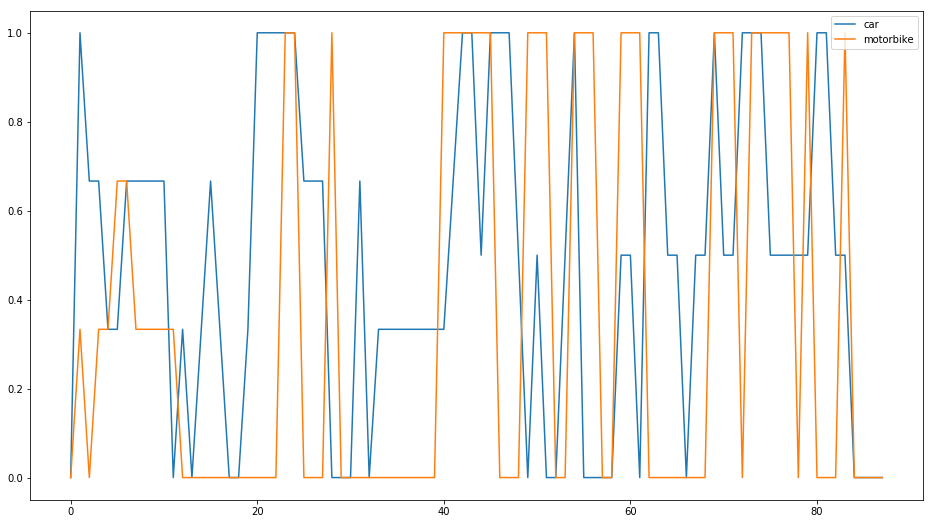

In [6]:
precision = calc_precision(test, experiment)

precision.plot(figsize=(16, 9))

In [7]:
test = vott_to_dataframe(test_file)

avg_precision = pd.DataFrame(index=test.columns)

avg_fps = pd.DataFrame(index=['1066x600' ])
avg_time = pd.DataFrame(index=['preprocessing', 'detection', 'tracking', 'postprocessing'])

for model in config.models:
    experiment_folder = os.path.join(config.base_folder, 'Videos', model)
    experiment_file = os.path.join(experiment_folder, annotations_file)
    
    experiment, times = vvc_to_df(experiment_file)
    
    precision = calc_precision(test, experiment)
    
    mean_precision = precision.mean().to_frame(model)
    
    avg_precision = avg_precision.join(mean_precision)
    
    # times
    
    mean_time = times[avg_time.index].mean().to_frame(model)
    
    avg_time = avg_time.join(mean_time)
    
    # fps
    
    total = times['total']
    
    fps = (total.count() / total.sum())*1000
        
    avg_fps[model] = fps


# dispay
display(avg_precision)

display(avg_time)

avg_fps

,frcnn-resnet50,frcnn-resnet50-transfer,frcnn-resnet50-tunned,yolov3,yolov3-transfer
car,0.299242,0.441288,0.369318,0.549242,0.486742
motorbike,0.100379,0.100379,0.087121,0.119318,0.363636


,frcnn-resnet50,frcnn-resnet50-transfer,frcnn-resnet50-tunned,yolov3,yolov3-transfer
preprocessing,45.546512,50.476744,47.186047,12.662791,13.127907
detection,498.569767,600.488372,565.081395,72.872093,57.151163
tracking,0.000000,0.000000,0.000000,0.000000,0.000000
postprocessing,23.720930,25.581395,24.720930,6.360465,5.976744


,frcnn-resnet50,frcnn-resnet50-transfer,frcnn-resnet50-tunned,yolov3,yolov3-transfer
1066x600,1.758008,1.47566,1.567255,10.748656,12.934276


<Figure size 432x288 with 0 Axes>

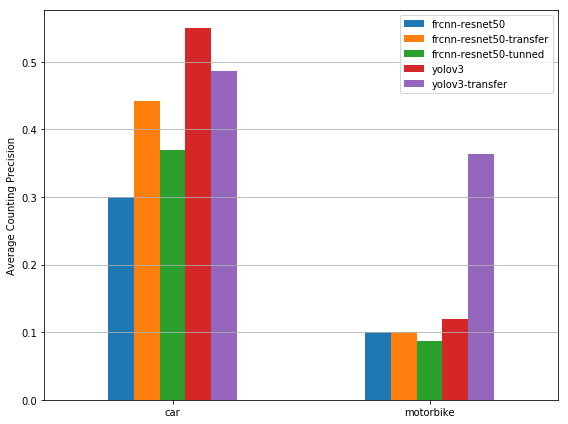

In [11]:
plt.figure()

ax = avg_precision.plot.bar(figsize=(8, 6), rot=0)

plt.grid(axis='y')

ax.set_ylabel('Average Counting Precision')

plt.tight_layout()

fig = ax.get_figure()
fig.savefig('./img/avg_precision.tif', dpi=300)

<Figure size 432x288 with 0 Axes>

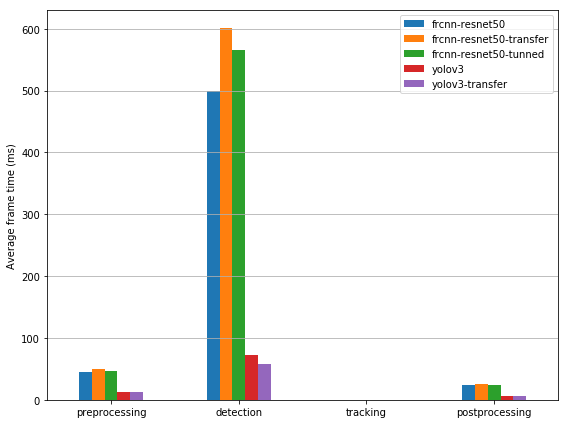

In [12]:
plt.figure()

ax = avg_time.plot.bar(figsize=(8, 6), rot=0)

plt.grid(axis='y')

ax.set_ylabel('Average frame time (ms)')

plt.tight_layout()

fig = ax.get_figure()
fig.savefig('./img/avg_time.tif', dpi=300)

<Figure size 432x288 with 0 Axes>

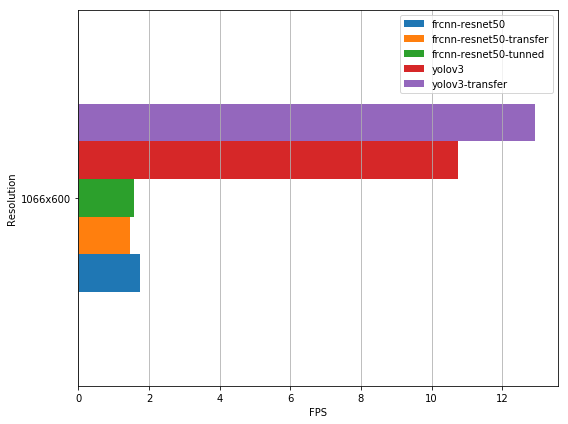

In [13]:
plt.figure()

ax = avg_fps.plot.barh(figsize=(8, 6))

plt.grid(axis='x')

ax.set_ylabel('Resolution')
ax.set_xlabel('FPS')

plt.tight_layout()

fig = ax.get_figure()
fig.savefig('./img/fps.tif', dpi=300)